In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as dates
import calplot

In [63]:
df1 = pd.read_csv('item5.csv')

In [64]:
df1[:10]

,Date,InvoiceId,Qty,Freight,LineAmount1,InvoiceCat,CustomerName,State,City,Year,Month,Day,Y-M,WeekDay
0,2018-02-11,DD-1819/540,232.0,0.00,36379.92,DD-1819,Customer 101,MH,RAIGAD,2018,2,11,2018-02,Sunday
1,2018-04-07,SGE-1819/3402,12.0,7.05,3046.32,SGE-1819,Customer 32,CH,CHANDIGARH,2018,4,7,2018-04,Saturday
2,2018-04-07,SGE-1819/3401,72.0,54.53,13968.00,SGE-1819,Customer 64,TS,SECUNDRABAD,2018,4,7,2018-04,Saturday
3,2018-04-09,SGE-1819/5496,10.0,0.00,2932.10,SGE-1819,Customer 112,MP,KATNI,2018,4,9,2018-04,Monday
4,2018-04-10,DD-1819/487,250.0,0.00,39202.50,DD-1819,Customer 130,DN,SILVASSA,2018,4,10,2018-04,Tuesday
5,2018-04-10,SGE-1819/6500,132.0,0.00,18955.20,SGE-1819,Customer 110,HR,GURGAON,2018,4,10,2018-04,Tuesday
6,2018-04-12,SGE-1819/8478,12.0,6.24,2855.36,SGE-1819,Customer 53,PB,LUDHIANA,2018,4,12,2018-04,Thursday
7,2018-05-07,SGE-1819/3431,12.0,0.00,3046.32,SGE-1819,Customer 32,CH,CHANDIGARH,2018,5,7,2018-05,Monday
8,2018-05-07,SGE-1819/3423,30.0,15.00,7615.80,SGE-1819,Customer 49,CT,BILASPUR,2018,5,7,2018-05,Monday
9,2018-05-09,SGE-1819/5541,19.0,10.92,5524.74,SGE-1819,Customer 35,MH,PUNE,2018,5,9,2018-05,Wednesday


In [65]:
len(set(df1.Date))

254

# AT DATE LEVEL

In [122]:
df_fin = df1[['Date','Qty','Freight','LineAmount1']].groupby(by='Date').agg(sum).reset_index()

In [123]:
#df1.groupby('Date')['CustomerName'].nunique().reset_index(name='no_of_unique_customers')
#df1[['Date','CustomerName']].groupby(['Date']).size().reset_index(name='no_of_orders').sort_values(by='Date')

In [124]:
def df_to_date_merger_multi_fields(doc_df, case_key, fields_predicted):
    df_rows = []
    grouped = doc_df.groupby(case_key)    
    for name, group in grouped:
        new_case_row = {case_key: name}

        for field_predicted in fields_predicted:
            field_extractions = []
            for _, row in group.iterrows():
                extractions = row[field_predicted]
                if isinstance(extractions, list):
                    field_extractions.extend(extractions)
                    continue

                field_extractions.append(extractions)
            if field_predicted=='State':
                field_extractions = list(set(field_extractions))
            field_extractions = list(field_extractions)
            new_case_row[field_predicted] = field_extractions
        df_rows.append(new_case_row)
    df = pd.DataFrame(df_rows)    
    return df

case_key = 'Date'
merge_fields = ['CustomerName', 'InvoiceCat','WeekDay','Month']

df_cat = df_to_date_merger_multi_fields(doc_df=df1, case_key=case_key, fields_predicted=merge_fields)

In [125]:
df_cat['WeekDay']=df_cat['WeekDay'].apply(lambda x: x[0])
df_cat['Month']=df_cat['Month'].apply(lambda x: x[0])
df_cat['no_unique_customers']=df_cat['CustomerName'].apply(lambda x: len(set(x)))
df_cat['no_orders']=df_cat['CustomerName'].apply(len)

In [126]:
def get_invoiceCat(inv_cat):
    DD,SGE=False,False
    
    for inv in inv_cat:
        if 'DD' in inv:
            DD = True
        if 'SGE' in inv:
            SGE= True
            
    if DD and SGE:
        return 'DD-SGE'
    elif DD:
        return 'DD'
    else:
        return 'SGE'
    
df_cat['InvoiceCat'] = df_cat['InvoiceCat'].apply(get_invoiceCat)

In [127]:
df_cat1 = pd.get_dummies(df_cat.set_index('Date')[['InvoiceCat','WeekDay','Month','no_unique_customers','no_orders']]).reset_index()

In [128]:
df_state = pd.get_dummies(df1.set_index('Date')['State'],prefix='State').groupby('Date').agg(max).reset_index()

In [129]:
df_fin = df_fin.merge(df_cat1, on='Date')

In [130]:
df_fin = df_fin.merge(df_state, on='Date')

In [131]:
df_fin.columns

Index(['Date', 'Qty', 'Freight', 'LineAmount1', 'Month', 'no_unique_customers',
       'no_orders', 'InvoiceCat_DD', 'InvoiceCat_DD-SGE', 'InvoiceCat_SGE',
       'WeekDay_Friday', 'WeekDay_Monday', 'WeekDay_Saturday',
       'WeekDay_Sunday', 'WeekDay_Thursday', 'WeekDay_Tuesday',
       'WeekDay_Wednesday', 'State_AP', 'State_AS', 'State_BH', 'State_CH',
       'State_CT', 'State_DL', 'State_DN', 'State_GA', 'State_GJ', 'State_HR',
       'State_JH', 'State_JK', 'State_KA', 'State_KL', 'State_MH', 'State_MP',
       'State_OR', 'State_PB', 'State_RJ', 'State_TN', 'State_TS', 'State_UP',
       'State_UT', 'State_WB'],
      dtype='object')

In [132]:
df_cat.InvoiceCat.value_counts()

SGE       177
DD-SGE     56
DD         21
Name: InvoiceCat, dtype: int64

In [133]:
df_cat.WeekDay.value_counts()

Thursday     45
Tuesday      44
Saturday     41
Wednesday    41
Friday       38
Monday       35
Sunday       10
Name: WeekDay, dtype: int64

In [134]:
df_cat.Month.value_counts()

6     34
11    34
8     28
12    28
10    24
9     22
4     19
7     18
3     15
5     14
2     10
1      8
Name: Month, dtype: int64

In [196]:
df_fin_all = df_fin.drop(['InvoiceCat_DD','WeekDay_Sunday'],axis=1).rename(columns = {'Qty':'sum_QTY','Freight':'sum_Freight','LineAmount1':'sum_LineAmount'})

In [197]:
df_fin_all['mean_sum_QTY'] = df_fin_all['sum_QTY']/df_fin_all['no_orders'] 

In [198]:
df_fin_all['Date'] = pd.to_datetime(df_fin_all['Date'])

In [199]:
df_fin_all[:3]

,Date,sum_QTY,sum_Freight,sum_LineAmount,Month,no_unique_customers,no_orders,InvoiceCat_DD-SGE,InvoiceCat_SGE,WeekDay_Friday,...,State_MP,State_OR,State_PB,State_RJ,State_TN,State_TS,State_UP,State_UT,State_WB,mean_sum_QTY
0,2018-02-11,232.0,0.00,36379.92,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,232.0
1,2018-04-07,84.0,61.58,17014.32,4,2,2,0,1,0,...,0,0,0,0,0,1,0,0,0,42.0
2,2018-04-09,10.0,0.00,2932.10,4,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,10.0


findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


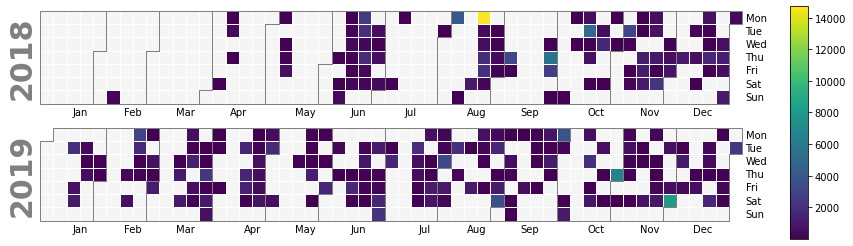

In [200]:
x=df_fin_all[['Date','sum_QTY']]
events=x['sum_QTY']
events.index=pd.to_datetime(x['Date'])
calplot.calplot(events)
plt.show()

findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.
findfont: Font family 'Helvetica' not found.


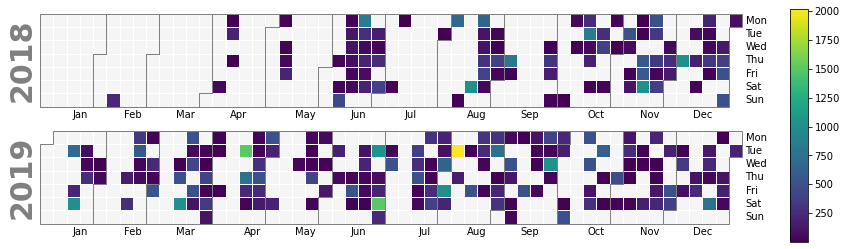

In [201]:
x=df_fin_all[['Date','mean_sum_QTY']]
events=x['mean_sum_QTY']
events.index=pd.to_datetime(x['Date'])
calplot.calplot(events)
plt.show()

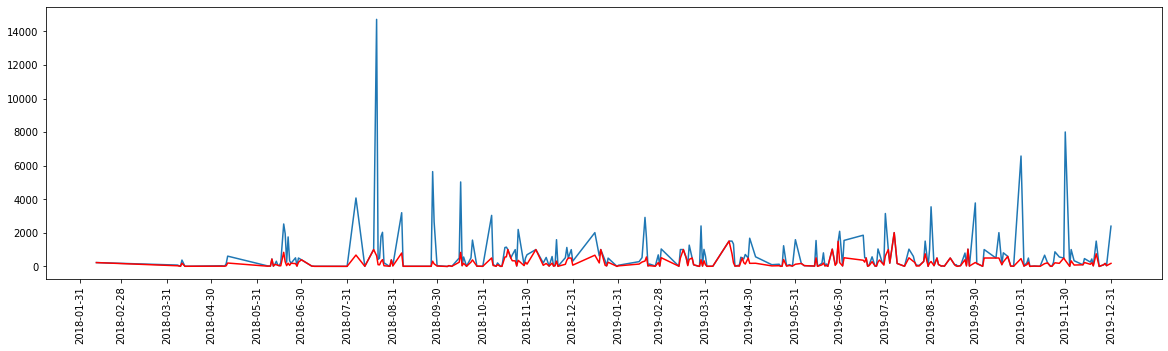

In [202]:
times = pd.date_range(start='2018-01-11',end='2019-12-31',freq='M')
plt.figure(figsize=(20, 5))
plt.plot(df_fin_all.Date, df_fin_all.sum_QTY)
plt.plot(df_fin_all.Date, df_fin_all.mean_sum_QTY,color='red')
plt.xticks(times,rotation=90)
plt.show()

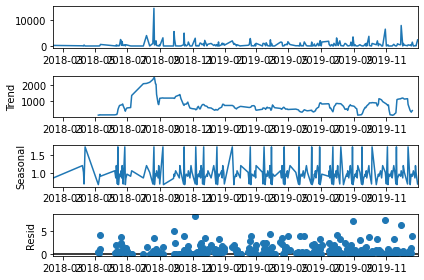

In [203]:
from statsmodels.tsa.seasonal import seasonal_decompose

data_orig = df_fin_all.set_index('Date')

analysis = data_orig[['sum_QTY']].copy()

decompose_result_mult = seasonal_decompose(analysis, model="multiplicative",period=10)

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

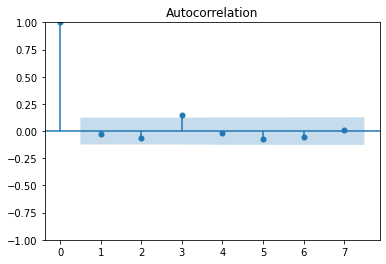

In [204]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_orig['sum_QTY'], lags=7)
plt.show()

In [205]:
df_fin_all.sort_values(by='sum_QTY',ascending=False)[:5]

,Date,sum_QTY,sum_Freight,sum_LineAmount,Month,no_unique_customers,no_orders,InvoiceCat_DD-SGE,InvoiceCat_SGE,WeekDay_Friday,...,State_MP,State_OR,State_PB,State_RJ,State_TN,State_TS,State_UP,State_UT,State_WB,mean_sum_QTY
34,2018-08-20,14723.0,10505.59,2793836.79,8,21,23,0,1,0,...,1,0,1,1,1,0,0,1,0,640.130435
239,2019-11-30,8013.0,5965.16,1795794.35,11,20,22,1,0,0,...,0,0,1,0,1,1,1,0,1,364.227273
222,2019-10-31,6581.0,4779.54,1306379.28,10,14,14,1,0,0,...,0,0,1,1,1,0,1,0,0,470.071429
47,2018-09-27,5653.0,3423.24,1054029.59,9,14,18,1,0,0,...,1,0,0,1,1,1,0,0,1,314.055556
54,2018-10-16,5036.0,3076.60,943269.00,10,6,6,1,0,0,...,1,0,0,1,0,0,0,0,0,839.333333


In [206]:
df_fin_all.iloc[34,df_fin_all.columns.get_loc('sum_QTY')] = 8400
df_fin_all.iloc[34,df_fin_all.columns.get_loc('sum_Freight')] = 10505.59*0.6
df_fin_all.iloc[34,df_fin_all.columns.get_loc('sum_LineAmount')] = 191.34*8400+1321

In [207]:
df_fin_all = df_fin_all[1:]

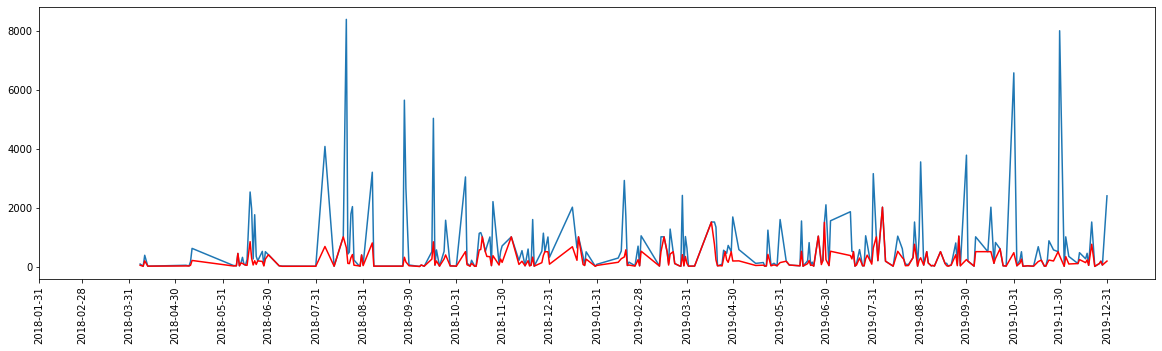

In [208]:
times = pd.date_range(start='2018-01-11',end='2019-12-31',freq='M')
plt.figure(figsize=(20, 5))
plt.plot(df_fin_all.Date, df_fin_all.sum_QTY)
plt.plot(df_fin_all.Date, df_fin_all.mean_sum_QTY,color='red')
plt.xticks(times,rotation=90)
plt.show()

In [209]:
df_fin_all = df_fin_all.set_index('Date')

In [210]:
df_fin_all['SMA30'] = df_fin_all['sum_QTY'].rolling(30,min_periods=1).mean()

In [211]:
df_fin_all['SMA7'] = df_fin_all['sum_QTY'].rolling(window=7,min_periods=1).mean()

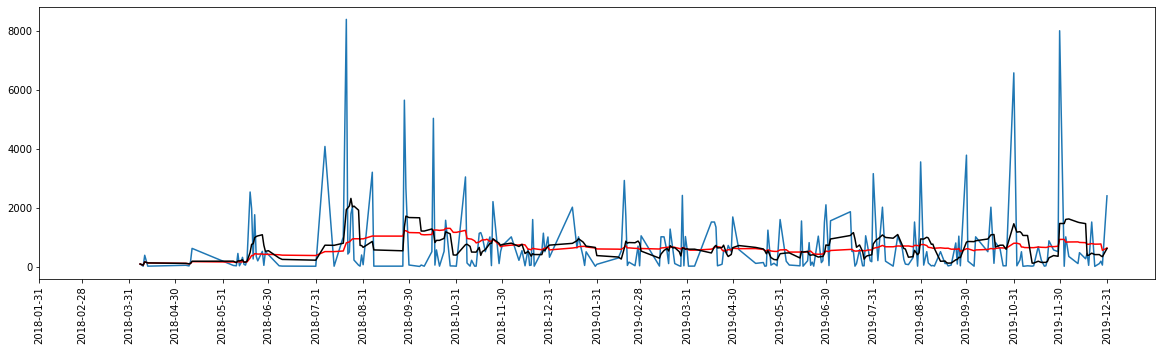

In [212]:
times = pd.date_range(start='2018-01-11',end='2019-12-31',freq='M')
plt.figure(figsize=(20, 5))
plt.plot(df_fin_all.index, df_fin_all.sum_QTY)
plt.plot(df_fin_all.index, df_fin_all.SMA30,color='red')
plt.plot(df_fin_all.index, df_fin_all.SMA7,color='black')
plt.xticks(times,rotation=90)
plt.show()

In [213]:
df_fin_all['CMA30'] = df_fin_all['sum_QTY'].expanding(30).mean()
df_fin_all['CMA7'] = df_fin_all['sum_QTY'].expanding(7).mean()

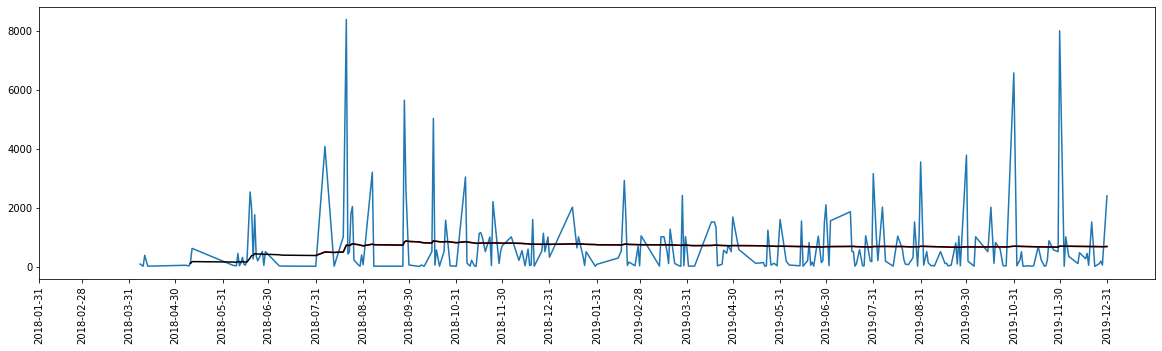

In [214]:
times = pd.date_range(start='2018-01-11',end='2019-12-31',freq='M')
plt.figure(figsize=(20, 5))
plt.plot(df_fin_all.index, df_fin_all.sum_QTY)
plt.plot(df_fin_all.index, df_fin_all.CMA30,color='red')
plt.plot(df_fin_all.index, df_fin_all.CMA7,color='black')
plt.xticks(times,rotation=90)
plt.show()

In [215]:
df_fin_all['EMA30'] = df_fin_all['sum_QTY'].ewm(span=30).mean()
df_fin_all['EMA7'] = df_fin_all['sum_QTY'].ewm(span=7).mean()

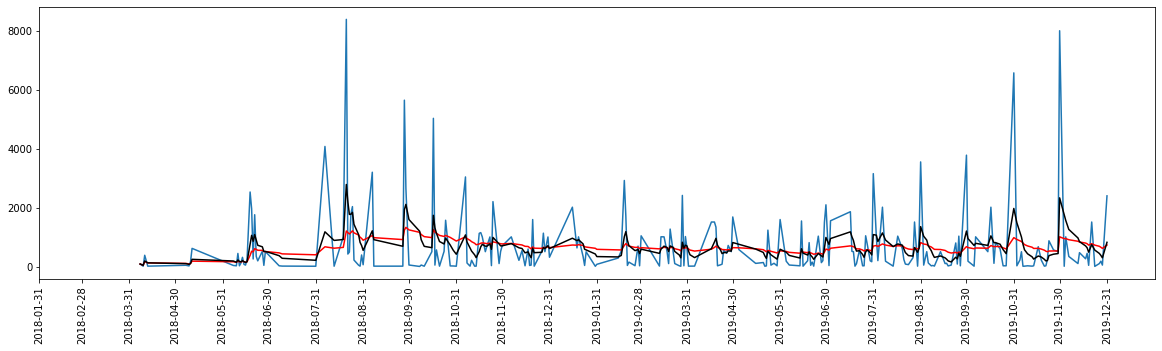

In [216]:
times = pd.date_range(start='2018-01-11',end='2019-12-31',freq='M')
plt.figure(figsize=(20, 5))
plt.plot(df_fin_all.index, df_fin_all.sum_QTY)
plt.plot(df_fin_all.index, df_fin_all.EMA30,color='red')
plt.plot(df_fin_all.index, df_fin_all.EMA7,color='black')
plt.xticks(times,rotation=90)
plt.show()

In [217]:
df_fin_all=df_fin_all.reset_index()

In [218]:
df_fin_all = df_fin_all.drop(['SMA30','CMA30','SMA7','CMA7','mean_sum_QTY'],axis=1)

In [219]:
df_fin_all[:3]

,Date,sum_QTY,sum_Freight,sum_LineAmount,Month,no_unique_customers,no_orders,InvoiceCat_DD-SGE,InvoiceCat_SGE,WeekDay_Friday,...,State_OR,State_PB,State_RJ,State_TN,State_TS,State_UP,State_UT,State_WB,EMA30,EMA7
0,2018-04-07,84.0,61.58,17014.32,4,2,2,0,1,0,...,0,0,0,0,1,0,0,0,84.000000,84.000000
1,2018-04-09,10.0,0.00,2932.10,4,1,1,0,1,0,...,0,0,0,0,0,0,0,0,45.766667,41.714286
2,2018-04-10,382.0,0.00,58157.70,4,2,2,1,0,0,...,0,0,0,0,0,0,0,0,165.396520,188.864865


# SELECTING ALL FEATURES BY USING LAG FOR PREV DATE DETAILS AND CREATING A SUPERVISED DATA

In [224]:
df_all_features = df_fin_all.copy()

In [225]:
df_all_features['sum_QTY_label'] = df_all_features['sum_QTY'].shift(-1)
df_all_features['Date_label'] = df_all_features['Date'].shift(-1)
df_all_features['Month'] = df_all_features['Month'].shift(-1)
df_all_features['WeekDay_Friday'] = df_all_features['WeekDay_Friday'].shift(-1)
df_all_features['WeekDay_Monday'] = df_all_features['WeekDay_Monday'].shift(-1)
df_all_features['WeekDay_Saturday'] = df_all_features['WeekDay_Saturday'].shift(-1)
df_all_features['WeekDay_Thursday'] = df_all_features['WeekDay_Thursday'].shift(-1)
df_all_features['WeekDay_Tuesday'] = df_all_features['WeekDay_Tuesday'].shift(-1)
df_all_features['WeekDay_Wednesday'] = df_all_features['WeekDay_Wednesday'].shift(-1)

In [226]:
df_all_features.columns

Index(['Date', 'sum_QTY', 'sum_Freight', 'sum_LineAmount', 'Month',
       'no_unique_customers', 'no_orders', 'InvoiceCat_DD-SGE',
       'InvoiceCat_SGE', 'WeekDay_Friday', 'WeekDay_Monday',
       'WeekDay_Saturday', 'WeekDay_Thursday', 'WeekDay_Tuesday',
       'WeekDay_Wednesday', 'State_AP', 'State_AS', 'State_BH', 'State_CH',
       'State_CT', 'State_DL', 'State_DN', 'State_GA', 'State_GJ', 'State_HR',
       'State_JH', 'State_JK', 'State_KA', 'State_KL', 'State_MH', 'State_MP',
       'State_OR', 'State_PB', 'State_RJ', 'State_TN', 'State_TS', 'State_UP',
       'State_UT', 'State_WB', 'EMA30', 'EMA7', 'sum_QTY_label', 'Date_label'],
      dtype='object')

In [227]:
df_all_features = df_all_features.drop(['Date'],axis=1)
df_all_features = df_all_features.rename(columns={'sum_QTY':'sum_QTY_before'})

In [229]:
df_all_features.to_csv('final_data_all_features.csv',index=False)

In [236]:
df_all_features

,sum_QTY_before,sum_Freight,sum_LineAmount,Month,no_unique_customers,no_orders,InvoiceCat_DD-SGE,InvoiceCat_SGE,WeekDay_Friday,WeekDay_Monday,...,State_RJ,State_TN,State_TS,State_UP,State_UT,State_WB,EMA30,EMA7,sum_QTY_label,Date_label
0,84.0,61.58,17014.32,4.0,2,2,0,1,0.0,1.0,...,0,0,1,0,0,0,84.000000,84.000000,10.0,2018-04-09
1,10.0,0.00,2932.10,4.0,1,1,0,1,0.0,0.0,...,0,0,0,0,0,0,45.766667,41.714286,382.0,2018-04-10
2,382.0,0.00,58157.70,4.0,2,2,1,0,0.0,0.0,...,0,0,0,0,0,0,165.396520,188.864865,12.0,2018-04-12
3,12.0,6.24,2855.36,5.0,1,1,0,1,0.0,1.0,...,0,0,0,0,0,0,123.130189,124.182857,42.0,2018-05-07
4,42.0,15.00,10662.12,5.0,2,2,0,1,0.0,0.0,...,0,0,0,0,0,0,104.671107,97.244558,19.0,2018-05-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,4.0,2.00,800.00,12.0,1,1,0,1,0.0,0.0,...,0,0,0,0,0,0,727.185082,558.695137,100.0,2019-12-26
249,100.0,0.00,16104.00,12.0,1,1,0,0,1.0,0.0,...,0,0,0,0,0,0,686.721526,444.021352,180.0,2019-12-27
250,180.0,107.17,30523.50,12.0,1,1,0,1,0.0,0.0,...,0,0,0,0,0,0,654.029813,378.016014,48.0,2019-12-28
251,48.0,14.16,13611.02,12.0,1,1,0,1,0.0,0.0,...,0,0,0,0,0,0,614.931113,295.512011,2401.0,2019-12-31


# SELECTING ALL FEATURES DEPENDING ON DATE AND QTY ONLY

In [231]:
df_filtered_features = df_all_features[['Date_label','sum_QTY_label','sum_QTY_before','Month','EMA30','EMA7','WeekDay_Friday', 
                                        'WeekDay_Monday','WeekDay_Saturday', 'WeekDay_Thursday', 'WeekDay_Tuesday','WeekDay_Wednesday']]

In [234]:
df_filtered_features = df_filtered_features[:-1]

In [235]:
df_filtered_features.to_csv('final_data_filtered_feat.csv',index=False)